In [2]:
import tensorflow as tf
import pathlib
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
from sklearn.model_selection import train_test_split
from tensorflow.keras import activations
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, SeparableConv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation, Add

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
country_images_root = pathlib.Path("/home/pascal_steiger/Downloads/data15/")

In [5]:
def load_image_paths(container_path):
    image_dir = pathlib.Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    descr = "A image classification dataset"
    image_paths = []
    flat_data = []
    target = []
    count = 0
    train_img_path = []
    train_label = []
    for i, direc in enumerate(folders):
        for file in direc.iterdir():
            count += 1
            train_img_path.append(str(file))
            train_label.append(categories[i])

    X = np.array(train_img_path)
    y = np.array(train_label)
    catStringArr = np.array(categories)

    return X, y, catStringArr

In [6]:
X = []
y = []
X, y, labelStringArr = load_image_paths("/home/pascal_steiger/Downloads/data15/")
img_df = pd.DataFrame(zip(X, y), columns=["path", "label"])

img_df.sample(n=10)

,path,label
11320,/home/pascal_steiger/Downloads/data15/POL/img_...,POL
12474,/home/pascal_steiger/Downloads/data15/CHE/img_...,CHE
4523,/home/pascal_steiger/Downloads/data15/GBR/img_...,GBR
309,/home/pascal_steiger/Downloads/data15/MKD/img_...,MKD
2113,/home/pascal_steiger/Downloads/data15/IRL/img_...,IRL
11121,/home/pascal_steiger/Downloads/data15/POL/img_...,POL
14638,/home/pascal_steiger/Downloads/data15/SWE/img_...,SWE
14608,/home/pascal_steiger/Downloads/data15/SWE/img_...,SWE
5970,/home/pascal_steiger/Downloads/data15/AUT/img_...,AUT
13989,/home/pascal_steiger/Downloads/data15/DNK/img_...,DNK


In [7]:
train_df, test_df = train_test_split(img_df, shuffle=True, test_size=0.2, random_state=42)


print(train_df.sample(n=5))
print(train_df.shape)
print(test_df.sample(n=5))
print(test_df.shape)

                                                   path label
3483  /home/pascal_steiger/Downloads/data15/ITA/img_...   ITA
25    /home/pascal_steiger/Downloads/data15/MKD/img_...   MKD
3538  /home/pascal_steiger/Downloads/data15/ITA/img_...   ITA
5129  /home/pascal_steiger/Downloads/data15/AUT/img_...   AUT
6210  /home/pascal_steiger/Downloads/data15/FIN/img_...   FIN
(12012, 2)
                                                    path label
8254   /home/pascal_steiger/Downloads/data15/PRT/img_...   PRT
7822   /home/pascal_steiger/Downloads/data15/NOR/img_...   NOR
2818   /home/pascal_steiger/Downloads/data15/IRL/img_...   IRL
10432  /home/pascal_steiger/Downloads/data15/EST/img_...   EST
7645   /home/pascal_steiger/Downloads/data15/NOR/img_...   NOR
(3003, 2)


In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col="path",
        y_col="label",
        target_size=(400, 400),
        batch_size=32,
        class_mode="sparse",
        seed=42
)


validation_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col="path",
        y_col="label",
        target_size=(400, 400),
        batch_size=32,
        class_mode="sparse",
        shuffle=False
)

Found 12012 validated image filenames belonging to 15 classes.
Found 3003 validated image filenames belonging to 15 classes.


In [9]:
with tf.device("/device:GPU:1"):   
    I = Input(shape=(400,400,3), dtype="float32")

    c2d1= Conv2D(32, (3, 3), (2, 2), activation="relu")(I)
    b1 = BatchNormalization()(c2d1)
    c2d2= Conv2D(64, (3, 3), activation="relu")(b1)
    b2 = BatchNormalization()(c2d2)

    c1d1= Conv2D(1, 1, (2, 2))(b2)
    b3 = BatchNormalization()(c1d1)

    sc2d1= SeparableConv2D(128, (3, 3), padding="same")(b2)
    b4 = BatchNormalization()(sc2d1)
    relu1= Activation(activations.relu)(b4)
    sc2d2= SeparableConv2D(128, (3, 3), padding="same")(relu1)
    b5 = BatchNormalization()(sc2d2)
    mp1= MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(b5)

    add1 = Add()([b3, mp1])

    c1d2= Conv2D(1, 1, (2, 2))(add1)
    b6 = BatchNormalization()(c1d2)

    relu2= Activation(activations.relu)(add1)
    sc2d3= SeparableConv2D(256, (3, 3), padding="same")(relu2)
    b7 = BatchNormalization()(sc2d3)
    relu3= Activation(activations.relu)(b7)
    sc2d4= SeparableConv2D(256, (3, 3), padding="same")(relu3)
    b8 = BatchNormalization()(sc2d4)
    mp2= MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(b8)

    add2 = Add()([b6, mp2])

    c1d3= Conv2D(1, 1, (2, 2))(add2)
    b9 = BatchNormalization()(c1d3)

    relu4= Activation(activations.relu)(add2)
    sc2d5= SeparableConv2D(728, (3, 3), padding="same")(relu4)
    b10 = BatchNormalization()(sc2d5)
    relu5= Activation(activations.relu)(b10)
    sc2d6= SeparableConv2D(728, (3, 3), padding="same")(relu5)
    b11 = BatchNormalization()(sc2d6)
    mp3= MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(b11)

    add3 = Add()([b9, mp3])

    relu6= Activation(activations.relu)(add3)
    sc2d7= SeparableConv2D(728, (3, 3), padding="same")(relu6)
    b12 = BatchNormalization()(sc2d7)
    relu7= Activation(activations.relu)(b12)
    sc2d8= SeparableConv2D(728, (3, 3), padding="same")(relu7)
    b13 = BatchNormalization()(sc2d8)

    add4 = Add()([add3, b13])

    relu8= Activation(activations.relu)(add4)
    sc2d9= SeparableConv2D(728, (3, 3), padding="same")(relu8)
    b14 = BatchNormalization()(sc2d9)
    relu9= Activation(activations.relu)(b14)
    sc2d10= SeparableConv2D(728, (3, 3), padding="same")(relu9)
    b15 = BatchNormalization()(sc2d10)

    add5 = Add()([add4, b15])

    relu10= Activation(activations.relu)(add5)
    sc2d11= SeparableConv2D(728, (3, 3), padding="same")(relu10)
    b16 = BatchNormalization()(sc2d11)
    relu11= Activation(activations.relu)(b16)
    sc2d12= SeparableConv2D(728, (3, 3), padding="same")(relu11)
    b17 = BatchNormalization()(sc2d12)

    add6 = Add()([add5, b17])

    relu12= Activation(activations.relu)(add6)
    sc2d13= SeparableConv2D(728, (3, 3), padding="same")(relu12)
    b18 = BatchNormalization()(sc2d13)
    relu13= Activation(activations.relu)(b18)
    sc2d14= SeparableConv2D(728, (3, 3), padding="same")(relu13)
    b19 = BatchNormalization()(sc2d14)

    add7 = Add()([add6, b19])

    relu14= Activation(activations.relu)(add7)
    sc2d15= SeparableConv2D(728, (3, 3), padding="same")(relu14)
    b20 = BatchNormalization()(sc2d15)
    relu15= Activation(activations.relu)(b20)
    sc2d16= SeparableConv2D(728, (3, 3), padding="same")(relu15)
    b21 = BatchNormalization()(sc2d16)

    add8 = Add()([add7, b21])

    c1d4= Conv2D(1, 1, (2, 2))(add8)
    b21 = BatchNormalization()(c1d4)

    relu16= Activation(activations.relu)(add8)
    sc2d17= SeparableConv2D(728, (3, 3), padding="same")(relu16)
    b22 = BatchNormalization()(sc2d17)
    relu17= Activation(activations.relu)(b22)
    sc2d18= SeparableConv2D(1024, (3, 3), padding="same")(relu17)
    b23 = BatchNormalization()(sc2d18)
    mp9= MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(b23)

    add9 = Add()([b21, mp9])

    sc2d19= SeparableConv2D(1536, (3, 3), activation="relu")(add9)
    b24 = BatchNormalization()(sc2d19)
    sc2d20= SeparableConv2D(2048, (3, 3), activation="relu")(b24)
    b25 = BatchNormalization()(sc2d20)

    gap = GlobalAveragePooling2D()(b25)

    flat = Flatten()(gap)
    dense = Dense(1024, activation='relu')(flat)
    dropout = Dropout(0.3)(dense)
    dense2 = Dense(512, activation='relu')(dropout)
    dropout2 = Dropout(0.1)(dense2)
    dense3 = Dense(15, activation='softmax')(dropout2)

    model = tf.keras.Model(I, dense3)

In [10]:
early_stopping = EarlyStopping(
    monitor='val_sparse_categorical_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_sparse_categorical_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [11]:
with tf.device("/device:GPU:1"):
    model.compile(optimizer = tf.optimizers.Nadam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [12]:
with tf.device("/device:GPU:1"):
    history = model.fit(train_generator,
      #steps_per_epoch=2000 // 32,  
      epochs=100,
      verbose=1,
      validation_data = validation_generator,
      callbacks = callbacks)

Epoch 1/100
376/376 [==============================] - 631s 2s/step - loss: 2.4866 - sparse_categorical_accuracy: 0.1819 - val_loss: 2.7507 - val_sparse_categorical_accuracy: 0.0686
Epoch 2/100
376/376 [==============================] - 612s 2s/step - loss: 2.2112 - sparse_categorical_accuracy: 0.2766 - val_loss: 3.3888 - val_sparse_categorical_accuracy: 0.1412
Epoch 3/100
376/376 [==============================] - 615s 2s/step - loss: 2.0913 - sparse_categorical_accuracy: 0.3168 - val_loss: 3.2388 - val_sparse_categorical_accuracy: 0.1755
Epoch 4/100
376/376 [==============================] - 612s 2s/step - loss: 2.0108 - sparse_categorical_accuracy: 0.3350 - val_loss: 2.1943 - val_sparse_categorical_accuracy: 0.2984
Epoch 5/100
376/376 [==============================] - 615s 2s/step - loss: 1.9420 - sparse_categorical_accuracy: 0.3622 - val_loss: 2.7992 - val_sparse_categorical_accuracy: 0.2601
Epoch 6/100
376/376 [==============================] - 614s 2s/step - loss: 1.8883 - spars

376/376 [==============================] - 614s 2s/step - loss: 0.5476 - sparse_categorical_accuracy: 0.8086 - val_loss: 1.4102 - val_sparse_categorical_accuracy: 0.6200
Epoch 46/100
376/376 [==============================] - 612s 2s/step - loss: 0.5492 - sparse_categorical_accuracy: 0.8102 - val_loss: 1.4854 - val_sparse_categorical_accuracy: 0.5904
Epoch 47/100
376/376 [==============================] - 620s 2s/step - loss: 0.5193 - sparse_categorical_accuracy: 0.8185 - val_loss: 1.5921 - val_sparse_categorical_accuracy: 0.5837
Epoch 48/100
376/376 [==============================] - 614s 2s/step - loss: 0.4981 - sparse_categorical_accuracy: 0.8224 - val_loss: 1.3832 - val_sparse_categorical_accuracy: 0.6214
Epoch 49/100
376/376 [==============================] - 612s 2s/step - loss: 0.4773 - sparse_categorical_accuracy: 0.8333 - val_loss: 1.6775 - val_sparse_categorical_accuracy: 0.5768
Epoch 50/100
376/376 [==============================] - 614s 2s/step - loss: 0.4587 - sparse_categ

Epoch 89/100
376/376 [==============================] - 615s 2s/step - loss: 0.1025 - sparse_categorical_accuracy: 0.9662 - val_loss: 1.8629 - val_sparse_categorical_accuracy: 0.6707
Epoch 90/100
376/376 [==============================] - 614s 2s/step - loss: 0.1009 - sparse_categorical_accuracy: 0.9671 - val_loss: 1.8679 - val_sparse_categorical_accuracy: 0.6693
Epoch 91/100
376/376 [==============================] - 613s 2s/step - loss: 0.1094 - sparse_categorical_accuracy: 0.9635 - val_loss: 1.9148 - val_sparse_categorical_accuracy: 0.6663

Epoch 00091: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 92/100
376/376 [==============================] - 613s 2s/step - loss: 0.0968 - sparse_categorical_accuracy: 0.9690 - val_loss: 1.8547 - val_sparse_categorical_accuracy: 0.6710
Epoch 93/100
376/376 [==============================] - 613s 2s/step - loss: 0.0797 - sparse_categorical_accuracy: 0.9738 - val_loss: 1.8800 - val_sparse_categorical_accuracy: 0.6747
Epoch

In [13]:
with tf.device("/device:GPU:1"):
    model.save('CNN_v5_fullNet-data15.h5')

/home/pascal_steiger/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


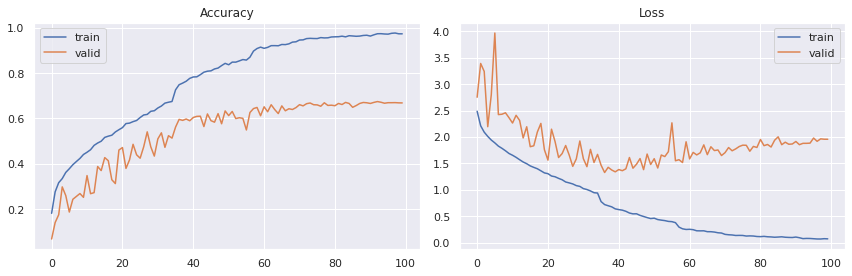

In [14]:
# plot training and validation metrics

sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['sparse_categorical_accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_sparse_categorical_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('CNN(400,400)_v5-data15.png')

plt.show()

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 199, 199, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 199, 199, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 197, 197, 64) 18496       batch_normalization[0][0]        
______________________________________________________________________________________________

In [10]:
model2 = tf.keras.models.load_model('CNN_v5_fullNet-data15.h5')

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
model2 = tf.keras.models.load_model('CNN_v5_fullNet-data15.h5')
num_of_test_samples=3003
batch_size=32

Y_pred = model2.predict(validation_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
target_names = sorted(labelStringArr)


print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[109   5   5   6   4   1   1   1   1  11   4   5  11   8   3]
 [  7 102   3   6   1   1  27  14   0  13   3   3  24   9   4]
 [  2   6 162   0   0   2   6   2   2   1   3   2   6   2   1]
 [  3  21   1  97   4   0   5  11   1   8   1   4   9   4   8]
 [  1   3   3   2 162   0   0   0   1   1   0   0  18   0   7]
 [  2   3   0   1   1 164   2   1   1   1   1   4   0   2   5]
 [  4  25   2  14   3   0  86  40   4   5   3   1  12   6   1]
 [  1  21   0   5   0   0  43 124   0   3   1   1   2   5   2]
 [  0   1   1   0   0   2   1   1 182   1   0   1   2   0   0]
 [  8   9   1   5   1   2   8   6   0 113  16   2  13  36   1]
 [  4   7   4   1   1   0   3   0   1   7 156   1   3  10   2]
 [  8   3   0   5   2  15   3   8   0   2   0 136   0   6  18]
 [  7   9   1   3   8   0   6   1   0   3   5   0 130   7   3]
 [  2  14   0   2   1   1   1   4   1  17   7   3   3 173   1]
 [  5   3   1  14  15  18   3   5   0   3   2  16   4   4 112]]
Classification Report
              p